In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.constants import R_jup, R_sun, R_earth, au, M_sun
import pandas as pd
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
from numpy import pi
from scipy import optimize

import bateman as bt
import thermalization as th
import heat_fission as ht
#import thermalization as th
#import heat as ht

kb =1.38064852e-16
h = 6.62607004e-27
c = 2.99792458e10
eV = 1.60218e-12
MeV = 1.0e6*eV
me = 9.10938356e-28
e = 4.803204e-10
mu = 1.66054e-24
day = 86400.
Msun = 1.9885e33

%matplotlib inline
%load_ext autoreload
%autoreload 2

Read effective opacities to gamma-rays for each elements.

In [2]:
#fkappa = pd.read_csv('effective_kappa_A141_238.dat',delim_whitespace=True,header=None)
fkappa = pd.read_csv('input_files/effective_kappa_A85_238.dat',delim_whitespace=True,header=None)
#fkappa = pd.read_csv('effective_kappa_141_238.dat',delim_whitespace=True,header=None)

kappa_effs = 0.02*np.ones((240,100))
for i in range(0,len(fkappa)):
    A = fkappa[0][i]
    Z = fkappa[1][i]
    kappa = np.sqrt(fkappa[3][i]*fkappa[4][i])
    kappa_effs[A][Z] = kappa


Read abundances (number fraction) of each beta-decay chain. 
The file format is
(Z A Y), where Z is an atomic number, A is an atomic mass number, and Y is a number fraction.

In [3]:
ffraction = pd.read_csv('input_files/solar_r_abundance_pattern.dat',delim_whitespace=True,header=None)

Define the range of atomic numbers of beta-decay chains and the ejecta model (density profile).
we use a radial density profile of merger ejecta with a total mass of 
$M_{\rm ej}$ and a minimum velocity of $v_0$:
\begin{eqnarray}
  \rho(t,v) = 
        \rho_0(t)\left(\frac{v_{\rm ej}}{v_0}\right)^{-n} for (v_0\leq v_{\rm ej}\leq v_{\rm max})
\end{eqnarray}
where $\rho_0(t)$ is defined such that 
\begin{eqnarray}
M_{\rm ej} = 4\pi \int_{v_0}^{v_{\rm max}}dvv^2 \rho(t,v).
\end{eqnarray}

In [12]:
##########Start input parameters
Amin = 88
Amax = 238

##########ejecta parameters for thermalization
Mej = 0.05*Msun
vej = 0.1*c
n = 4.5
alpha_max = 4.0#v_max = alpha_max * vej
alpha_min = 1.#v_min = alpha_min * vej

Calculate the beta decay radioactive power and heating rate.

In [9]:
beta = ht.calc_heating_rate(Mej,vej, Amin,Amax,ffraction,kappa_effs,alpha_max,alpha_min,n)

Input abundances (number fraction) of each element.

fission_A = atomic mass number of an element disintegrated via spontaneous fission.

fission_Y = number abundance of an element disintegrated via spontaneous fission.

In [5]:
######### fission nuclide 254Cf ########
ffission_A = []
ffission_Y =[]
ffission_A.append(254) #atomic mass number
ffission_Y.append(2.0e-6) #number abundance

Calculate the spontaneous fission radioactive power and heating rate.

In [6]:
fission = ht.calc_heating_rate_sf(Mej,vej, Amin,Amax,ffraction,ffission_A,ffission_Y,kappa_effs,alpha_max,alpha_min,n)

Save the data.

In [10]:
data = {'t':beta['t'],'total':beta['total'],'gamma':beta['gamma'], 'electron':beta['electron'], 'gamma_th':beta['gamma_th'],'electron_th':beta['electron_th']}
df = pd.DataFrame(data=data)
df.to_csv('output_files/heat_beta_88_209_M005_v04_v1_n45.dat',sep=" ",index=False,header=None,columns=['t', 'total', 'gamma', 'electron','gamma_th','electron_th'])

In [8]:
data = {'t':fission['t'],'total':fission['fission'],'fission_th':fission['fission_th']}
df = pd.DataFrame(data=data)
df.to_csv('output_files/heat_fission_M005_v04_v1_n45.dat',sep=" ",index=False,header=None,columns=['t', 'total', 'fission_th'])

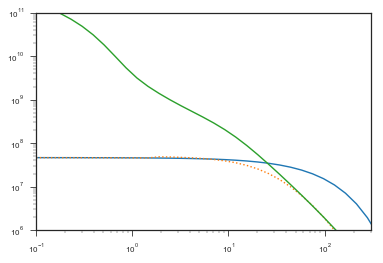

In [14]:
plt.ylim(1.0e6,1.0e11)
plt.xlim(0.1,300.)
plt.loglog(fission['t'],np.multiply(fission['fission'],1.))
plt.loglog(fission['t'],np.multiply(fission['fission_th'],1.),linestyle=':')
plt.loglog(beta['t'],np.multiply(beta['electron_th'],1.),linestyle='-')
plt.savefig('output_files/heat.pdf')
plt.show()